In [1]:
%env CUDA_VISIBLE_DEVICES=6

env: CUDA_VISIBLE_DEVICES=6


### Running GQ-CNN inference on our dataset

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from dexnet.grasp_model import DexNetBase as GQCNN
from dexnet.torch_dataset import Dex3Dataset as DexDataset
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms


In [37]:
# path to directory containing "tensors" folder
dataset_path = Path("dataset/dexnet_3/dexnet_09_13_17")

# path to model checkpoint
#model_path = "model_zoo/DexNetBaseSuction.pth"
model_path = "model_zoo/DexNetBaseSuction"

In [9]:
dataset = DexDataset(dataset_path)

Loaded data in 19.78 seconds.


In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("WARNING: using cpu")

model = GQCNN()
weights = torch.load(model_path)
model.load_state_dict(weights)
model = model.to(device)
model.eval()

samples = np.random.choice(2000000, 256, replace=False)
model_input = torch.stack([dataset[i][0] for i in samples])
gt_data = torch.stack([dataset[i][1] for i in samples])

print(model_input.shape)
print(gt_data.shape)

torch.Size([256, 1, 32, 32])
torch.Size([256])


In [31]:
model_input = model_input.to(device)
outputs = model(model_input).cpu()

# Let's see what scores our model predicted for the positive grasps!
pos_idx = torch.where(gt_data > .2)

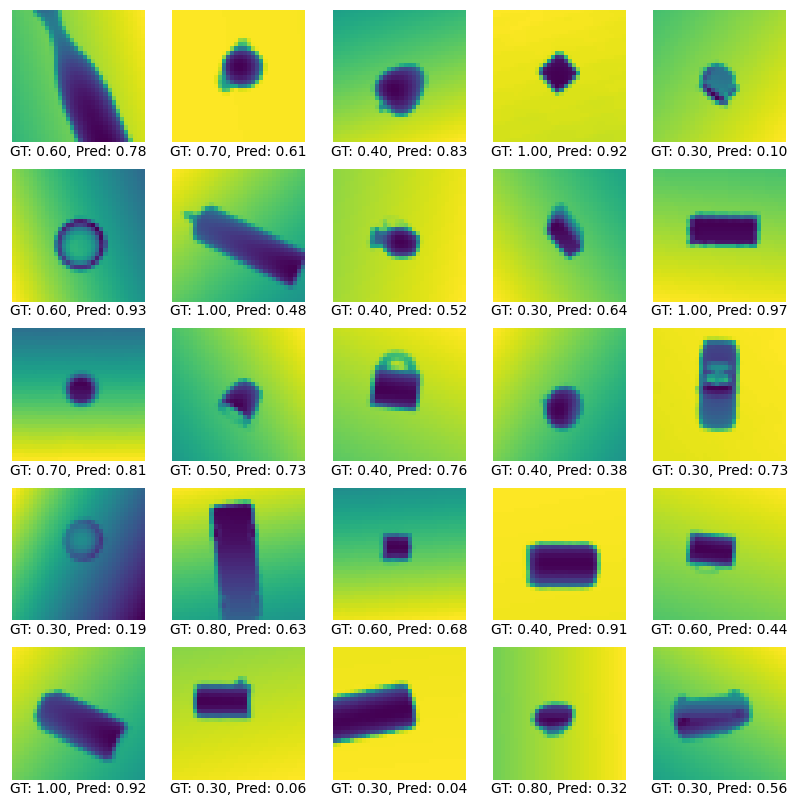

In [36]:
model_input = model_input.cpu()
pos_images = model_input[pos_idx]
labels = gt_data[pos_idx]
predictions = outputs[pos_idx]

# Visualizing positive suction grasp images

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(np.min([25, len(pos_images)])):
    ax = axes[i // 5, i % 5]  # Determine the subplot position
    ax.imshow(pos_images[i].permute(1, 2, 0))
    ax.axis('off')  # Turn off axis for cleaner display
    ax.text(0.5, -0.1, f"GT: {labels[i].item():.2f}, Pred: {predictions[i].item():.2f}", 
            transform=ax.transAxes, ha="center")  # Add label and prediction as text at the bottom


plt.show()

### Running FC-GQ-CNN inference on other depth images

In [134]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from dexnet.grasp_model import DexNetBase as GQCNN
from dexnet.torch_dataset import Dex3Dataset as DexDataset
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms

In [145]:
import cv2
from dexnet.grasp_model import BaseFCGQCNN as FCGQCNN
from dexnet.grasp_model import HighResFCGQCNN as HighResFCGQCNN

In [146]:
model_path = "model_zoo/DexNetFCGQCNNSuction.pth"
depth_im_path = "example_depth.npy"

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("WARNING: using cpu")

In [147]:
model = FCGQCNN()
weights = torch.load(model_path)
model.load_state_dict(weights)
model = model.to(device)
model.eval()

BaseFCGQCNN(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (lrn): LocalResponseNorm(2, alpha=2e-05, beta=0.75, k=1.0)
  (conv5): Conv2d(64, 1024, kernel_size=(16, 16), stride=(1, 1))
  (conv6): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
  (conv7): Conv2d(1024, 1, kernel_size=(1, 1), stride=(1, 1))
  (sigmoid): Sigmoid()
)

In [160]:
"""Image pre-processing functions"""

def blur(img):
    kernel = np.ones((15,15), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)
    img = cv2.GaussianBlur(img, (15, 15), 5)

    return img

def processNumpy(img):
    """
    example preprocessing for numpy depth image shape (width, height, 1) before inference
    blurs, normalizes, resizes, pads, and converts to tensor
    NOT batched operation.
    """

    img = blur(img)

    img = (img - img.mean()) / img.std()
    img = cv2.resize(img, (40, 40))

    pad = 15
    img = cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_REPLICATE)

    img = torch.tensor(img, dtype=torch.float32).squeeze().unsqueeze(0)

    return img

torch.Size([1, 1, 70, 70])


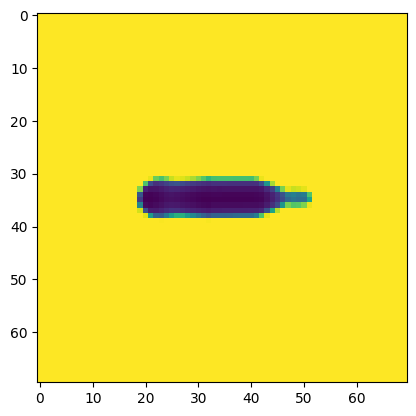

In [161]:
depth_im = np.load("example_depth.npy")

# this image happens to be inverted
depth_im = 255 - depth_im
depth_im_to_display = depth_im

assert len(depth_im.shape) == 3 and depth_im.shape[2] == 1, "image expected to be (, W, 1) for this demo, image is shape: {depth_im.shape}"
"""
Note that this processNumpy function is not batched 
and should be adjusted based on your image distrbution
"""
depth_im = processNumpy(depth_im)

"""
We need to lower the resolution of our image so that the 32x32 crops still contain large portions of the object.
This keeps the images in distribution
We also add padding so we'll make predictions at the edge of the original image
"""
plt.imshow(depth_im.squeeze().unsqueeze(-1))

# The image we feed into our model should be shape (B, 1, H, W)
depth_im = depth_im.unsqueeze(0)
print(depth_im.shape)

In [162]:
depth_im = depth_im.to(device)
output_heatmap = model(depth_im).cpu()
output_heatmap = output_heatmap.squeeze().unsqueeze(-1).detach().numpy()

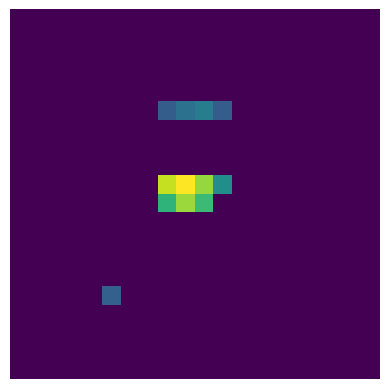

In [163]:
filtered_heatmap = output_heatmap
filtered_heatmap[output_heatmap <= .2] = 0
plt.axis("off")
plt.imshow(filtered_heatmap)

torch.Size([1, 1, 19, 19])
torch.Size([1, 1, 19, 19])
torch.Size([1, 1, 19, 19])
torch.Size([1, 1, 19, 19])
(38, 38, 1)


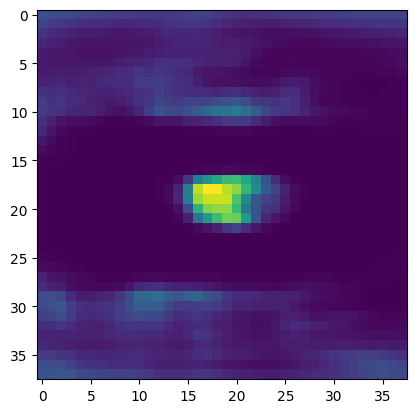

In [164]:
depth_im = depth_im.to(device)

high_res_model = HighResFCGQCNN() 
high_res_model.load_state_dict(torch.load(model_path))
high_res_model = high_res_model.to(device)

high_res_model(depth_im)

output_heatmap = high_res_model(depth_im).cpu()
output_heatmap = output_heatmap.squeeze().unsqueeze(-1).detach().numpy()
print(output_heatmap.shape)
plt.imshow(output_heatmap)


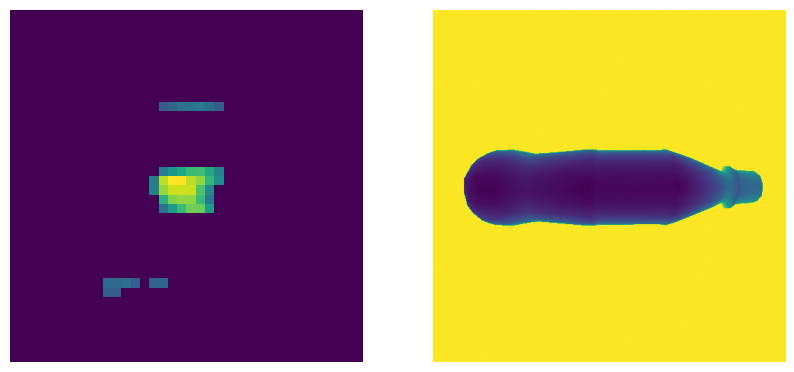

In [165]:

filtered_heatmap = output_heatmap
filtered_heatmap[output_heatmap <= .2] = 0
depth_im = depth_im.cpu()

fig, axes = plt.subplots(1, 2, figsize=(10, 8))
axes[0].imshow(filtered_heatmap)
axes[0].axis('off')
axes[1].imshow(depth_im_to_display)
axes[1].axis('off')

plt.show()